In [6]:
import timm
import torch
from skimage import io
import cv2
from matplotlib import pyplot as plt

In [3]:
class GradCam:
    def __init__(self, model, target):
        self.model = model.eval()
        self.feature = None
        self.gradient = None
        self.handlers = []
        self.target = target
        self._get_hook()

    def _get_features_hook(self, module, input, output):
        self.feature = self.reshape_transform(output)

    def _get_grads_hook(self, module, input_grad, output_grad):
        def _store_grad(grad):
            self.gradient = self.reshape_transform(grad)
        output_grad.register_hook(_store_grad)

    def _get_hook(self):
        self.target.register_forward_hook(self._get_features_hook)
        self.target.register_forward_hook(self._get_grads_hook)

    def reshape_transform(self, tensor, height=14, width=14):
        result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
        result = result.transpose(2, 3).transpose(1, 2)
        return result

    def __call__(self, inputs):
        self.model.zero_grad()
        output = self.model(inputs)
        index = np.argmax(output.cpu().data.numpy())
        target = output[0][index]
        target.backward()
        gradient = self.gradient[0].cpu().data.numpy()
        weight = np.mean(gradient, axis=(1, 2))
        feature = self.feature[0].cpu().data.numpy()
        cam = feature * weight[:, np.newaxis, np.newaxis]
        cam = np.sum(cam, axis=0)
        cam = np.maximum(cam, 0)
        cam -= np.min(cam)
        cam /= np.max(cam)
        cam = cv2.resize(cam, (224, 224))
        return cam

In [4]:
def prepare_input(image):
    image = image.copy()
    means = np.array([0.5, 0.5, 0.5])
    stds = np.array([0.5, 0.5, 0.5])
    image -= means
    image /= stds
    image = np.ascontiguousarray(np.transpose(image, (2, 0, 1)))
    image = image[np.newaxis, ...]
    return torch.tensor(image, requires_grad=True)

def gen_cam(image, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = (1 - 0.5) * heatmap + 0.5 * image
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


Grad-CAM heatmap saved to /content/result.jpg


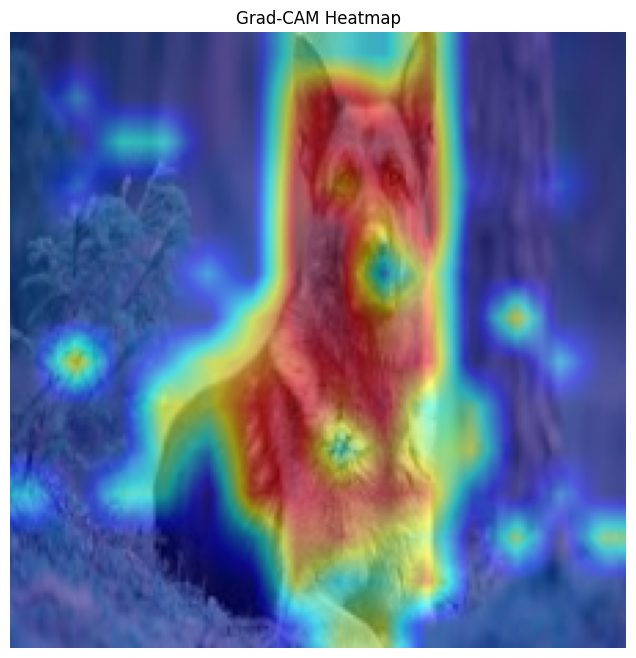

In [7]:
if __name__ == '__main__':
    img = io.imread("/content/dog.jpg")
    img = np.float32(cv2.resize(img, (224, 224))) / 255
    inputs = prepare_input(img)
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    target_layer = model.blocks[-1].norm1
    grad_cam = GradCam(model, target_layer)
    mask = grad_cam(inputs)
    result = gen_cam(img, mask)
    cv2.imwrite('/content/result.jpg', result)
    print("Grad-CAM heatmap saved to /content/result.jpg")


    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Grad-CAM Heatmap")
    plt.show()